In [2]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
#plt.gray()
galaxy_name = 'DDO154'
box_size = 200
window_size = (40, 40)


# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 154\d154u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 154\d154b.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 154\d154v.fits")
light_v = light_file_v[0].data

box_u = (100 , 100)
box_b = (130 , 130)
box_v = (170 , 170)

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]

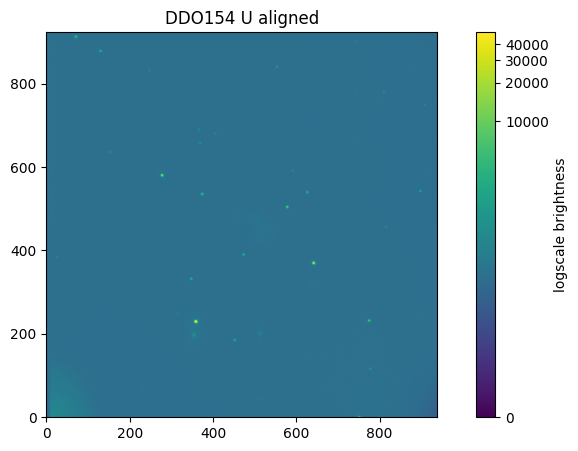

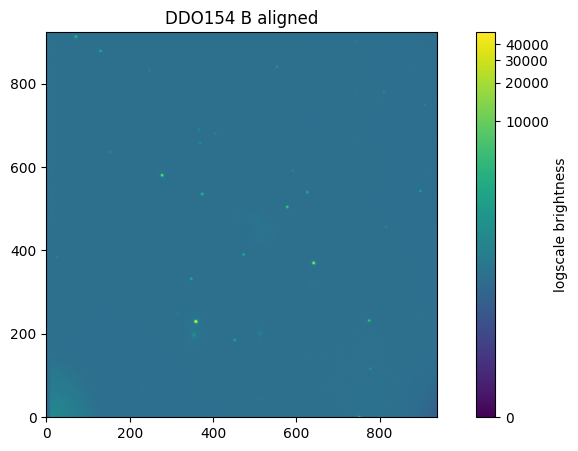

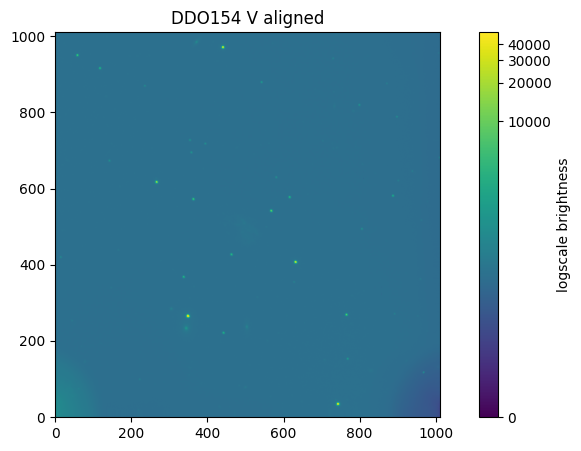

In [3]:
aligned = ltf.align(lights,[0,1],2)
for i in range(0,3):
    ltf.log_scale_plot(aligned[i],"%s %s aligned"%(galaxy_name,filters[i]),"logscale brightness")

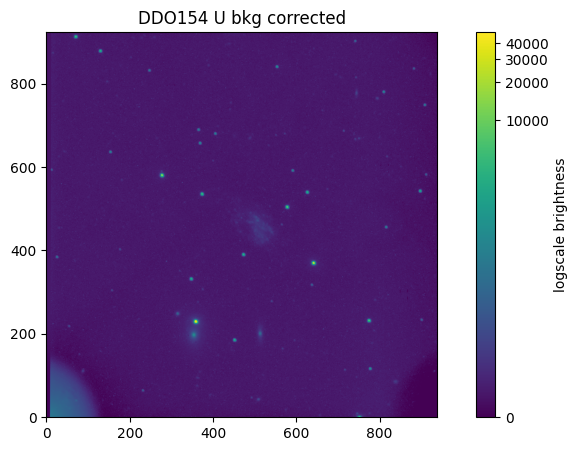

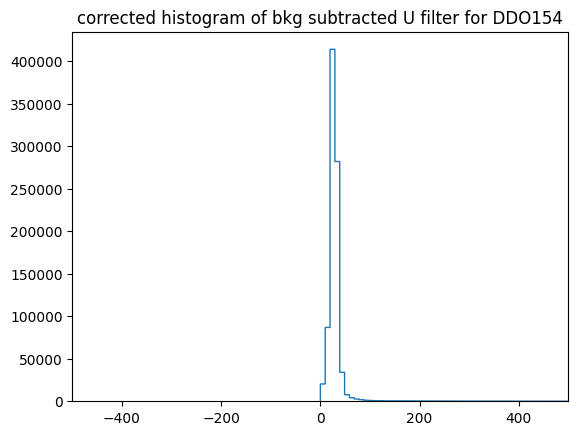

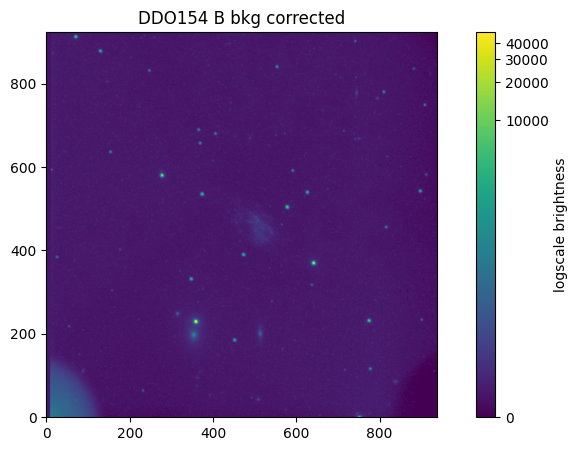

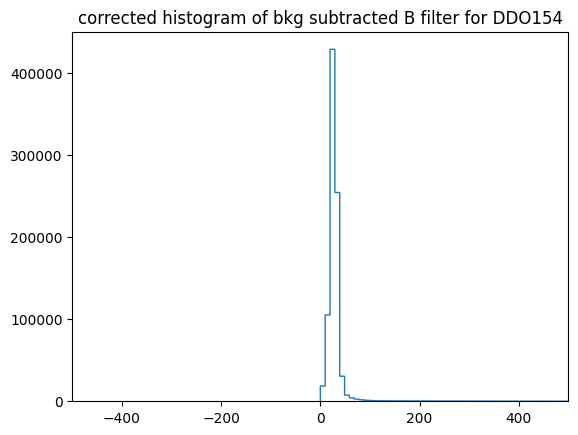

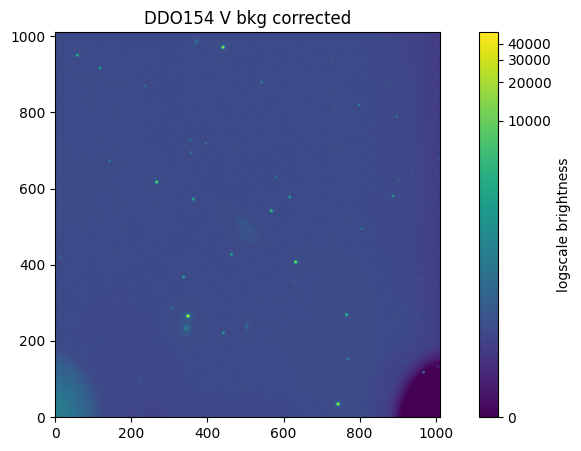

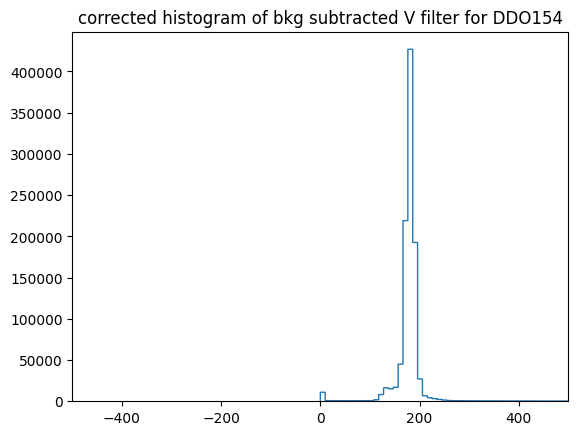

In [4]:
corrected = ltf.background_subtraction(aligned,3,boxes,(3,3))
for i in range(0,3):
    ltf.log_scale_plot(corrected[i],"%s %s bkg corrected"%(galaxy_name,filters[i]),"logscale brightness")
    counts, bins = np.histogram(corrected[i], 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("corrected histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()

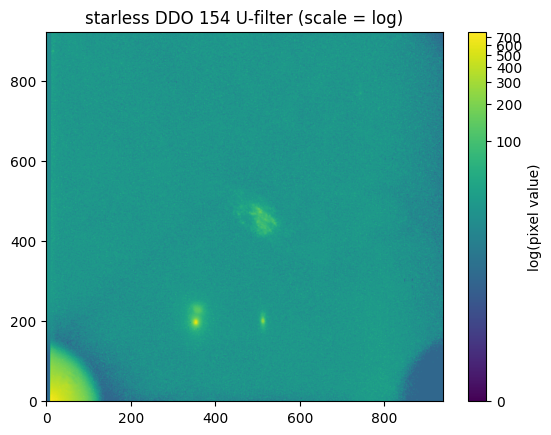

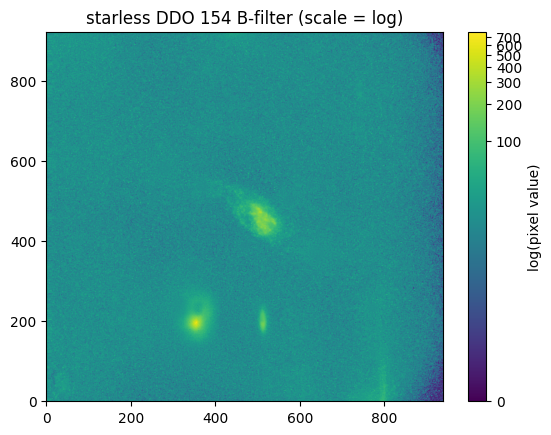

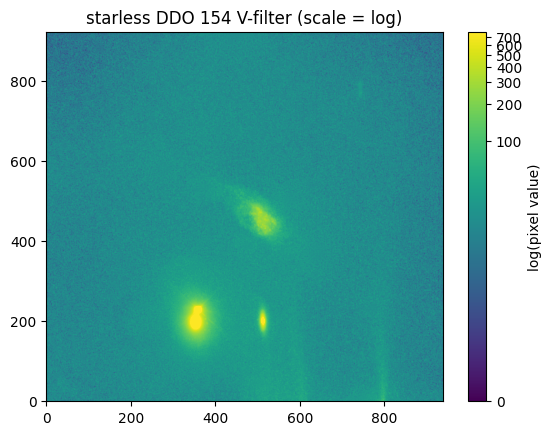

In [5]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------
starless_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_U_background_subtracted.fit")
starless_u = starless_file_u[0].data
starless_u[starless_u <= 0] = 1
starless_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_B_background_subtracted.fit")
starless_b = starless_file_b[0].data
starless_b[starless_b <= 0] = 1
starless_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_V_background_subtracted.fit")
starless_v = starless_file_v[0].data
starless_v[starless_v <= 0] = 1

starless = [starless_u , starless_b , starless_v]

norm = ImageNormalize(vmin=0., stretch=LogStretch())
for i in range(0 , len(starless)):
    
    plt.imshow(starless[i] , origin = "lower" , aspect='auto', norm = norm)
    plt.title('starless DDO 154 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

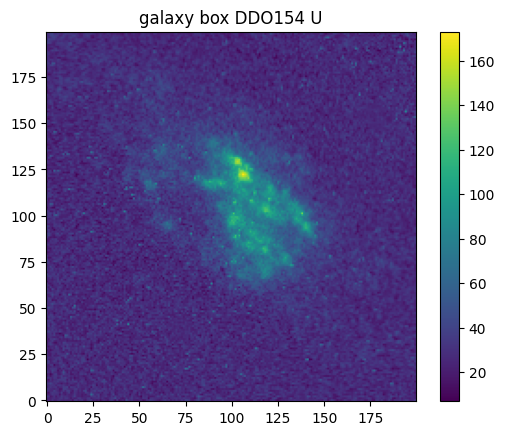

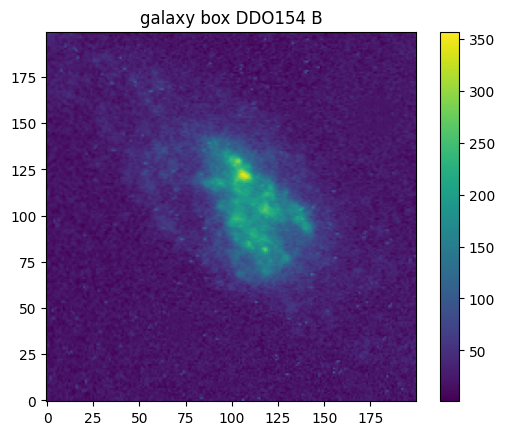

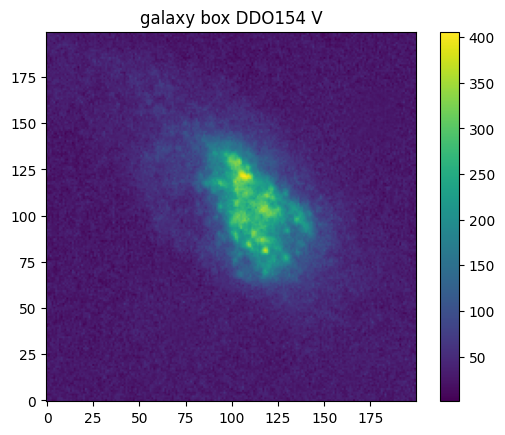

In [6]:
import little_things_functions as ltf
galaxy_boxes = ltf.get_boxes(starless,[500,450],200)
for i in range(0,3):
    plt.imshow(galaxy_boxes[i], origin = "lower")
    plt.title("galaxy box %s %s"%(galaxy_name,filters[i]))
    plt.colorbar()
    plt.show()
    

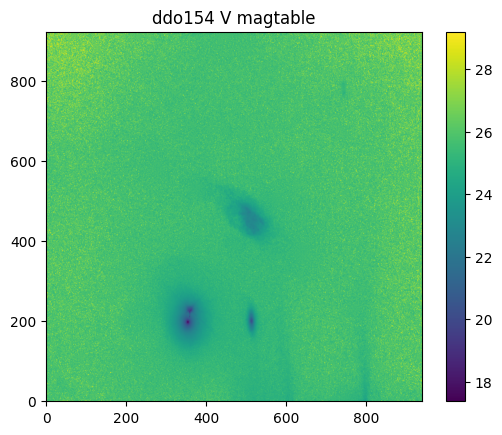

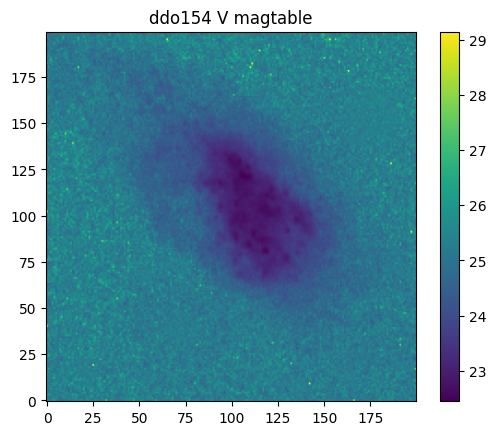

In [7]:
airmass_values=[1.16, 1.49, 1.11]
pixel_scale = 1.134
exposures = [1800, 1200, 600]
mU_values = [5.196, 0.4683865, -0.093,  0.]
mB_values = [3.562, 0.2586217, -0.0166, 0.]
mV_values = [3.017, 0.128904 ,  0.045,  0.]
m_values = [mU_values,mB_values,mV_values]

plt.imshow(ltf.mag_table_correction(starless,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

plt.imshow(ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

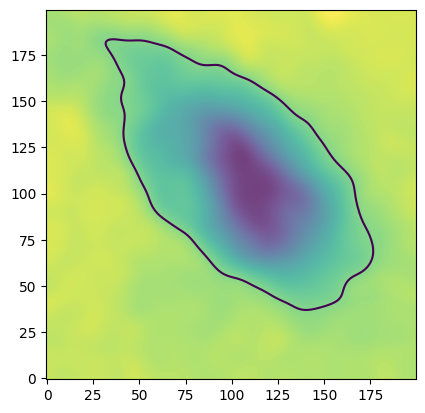

In [8]:
v_box = ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2]
contour_points = ltf.contour_lines_coordinates(v_box, 5, [25])
x_points , y_points = contour_points

In [9]:
image_center_of_mass = ndimage.center_of_mass(v_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]

(99.45652097762529, 99.36669895573858)


[104.56636068 109.52377357  44.49206359  89.36009418   7.06629674]


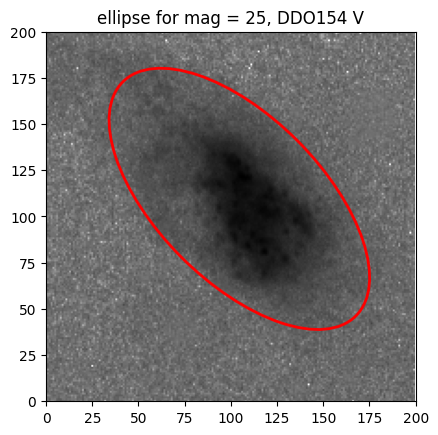

In [11]:
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_box.shape[1])
ax.set_ylim(0,v_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for mag = 25, DDO154 V")
# Show the plot
plt.show()